# Project Oxford: Face API


In [44]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter
import httplib, urllib, base64 #General API Usage

In [45]:
# Variables

_url_detect = 'https://api.projectoxford.ai/face/v1.0/detect'
_url_verify = 'https://api.projectoxford.ai/face/v1.0/verify'
_key = '0b8afa8909154432bafeed6a3217fcde' #Here you have to paste your primary key
_maxNumRetries = 10

## 1. Face Detection (To get faceId)

In [46]:
def detectionRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url_detect, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [47]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""

    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 1 )

        faceLandmarks = currFace['faceLandmarks']

        for _, currLandmark in faceLandmarks.items():
            cv2.circle( img, (int(currLandmark['x']),int(currLandmark['y'])), color = (0,255,0), thickness= -1, radius = 1 )

    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        faceAttributes = currFace['faceAttributes']

        textToWrite = "%c (%d)" % ( 'M' if faceAttributes['gender']=='male' else 'F', faceAttributes['age'] )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1 )

#TODO: face detection

폴더 내에 있는 페이스 아이디 불러오기

In [158]:
cur_dir = '/Users/robot/git_ryan/MS_Face_API/image/Test_shin/'
test_file = os.listdir(cur_dir)

test_faceId = []
file_name = [] #directory file name

for i in xrange(0, len(test_file)):
    file_name.append(cur_dir + test_file[i])
    
    with open (file_name[i], 'rb') as f:
        data = f.read()

    try:
        result = detectionRequest( json, data, headers, params )
        test_faceId.append( result[0]['faceId'])
        time.sleep(1)
        print("")
    except:
        print("filename: %s" %file_name[i])

In [160]:
test_faceId

[u'c9d3fac3-af20-486f-840c-4e08ce377d02',
 u'32fc44bc-3129-48e0-bf4a-ed98eb7d4568',
 u'becebebd-dc2b-481f-9d28-5e3eb284360b',
 u'0ec77977-cd2f-49ee-b4c3-088d94887848',
 u'68e89ad9-224b-489f-b52a-0f83e7f8de98',
 u'c7ddbdff-99ff-45c6-a3b0-6ed30bdbedc0',
 u'e769b5a6-4459-4040-ab66-6b49375d4677',
 u'4efa36e1-c2aa-4202-b58a-bd37d55923aa',
 u'f4d3bdec-7e75-442d-baf7-5b2841390f13',
 u'f2209042-7ad0-4442-9c8e-1e83b2214043',
 u'432d9726-e6bc-4fae-9de8-794eac9742d6',
 u'd1588d75-8013-4e4f-b2f5-863df96c2d48',
 u'08f81c2e-74d6-4ac7-ae83-5ce09baae6ac',
 u'ba165fb8-432a-47cd-ab2b-37f55bb96b9d']

u'77d152e5-916a-41d8-a767-fbcb0cd7f7dd'

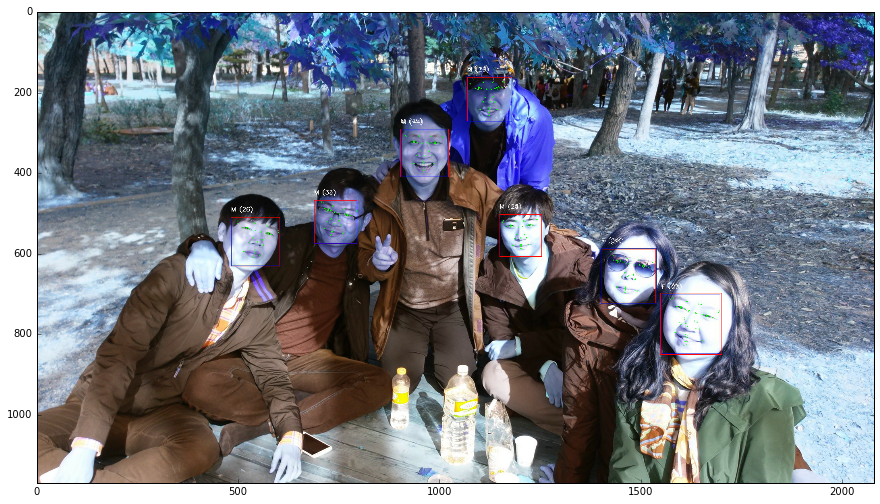

In [49]:
# Face detection parameters
params = { 'returnFaceAttributes': 'age,gender', 
           'returnFaceLandmarks': 'true'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/octet-stream'

json = None

## Load raw image file into memory
#pathToFileInDisk = r"/home/ryan/Pictures/lim/" + first_file
pathToFileInDisk = r"/Users/robot/git_ryan/MS_Face_API/hello.jpg"
with open( pathToFileInDisk, 'rb' ) as f:
    data = f.read()


result = detectionRequest( json, data, headers, params )


if result is not None:
    # Load the original image from disk
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )
    
result[0]['faceId']

## 2. Face Verification (Need faceId)

In [166]:
def verificationRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url_verify, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [192]:
print(test_faceId[4])
print(test_faceId[5])
print(test_file[0])
print(test_file[1])

In [195]:
# Face Simliarity parameters

#params = { 'faceId1': 'a0747ea2-b8a3-44ec-80f0-04b6a8b0f6cc', 
#           'faceId2': '77a2d1d0-c43f-4033-bfc5-c5af55ffe72c'} 

params = None

headers = dict()

headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json'
                                                    
#json = None

data = None

for i in xrange(len(test_file)):
    json = { 'faceId1': test_faceId[i], 'faceId2': test_faceId[i+1] } 
    result = verificationRequest( json, data, headers, params )
    print(result)

#print(result)
#print(result["isIdentical"])
#print(result["confidence"])


#print(result[0]["faceId"])
#a0747ea2-b8a3-44ec-80f0-04b6a8b0f6cc
#77a2d1d0-c43f-4033-bfc5-c5af55ffe72c

KeyboardInterrupt: 

In [30]:
    def renderResultOnImage( result, img ):

        """Display the obtained results onto the input image"""

        for currFace in result:
            faceRectangle = currFace['faceRectangle']
            cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                               (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                           color = (255,0,0), thickness = 1 )

            faceLandmarks = currFace['faceLandmarks']

            for _, currLandmark in faceLandmarks.items():
                cv2.circle( img, (int(currLandmark['x']),int(currLandmark['y'])), color = (0,255,0), thickness= -1, radius = 1 )

        for currFace in result:
            faceRectangle = currFace['faceRectangle']
            faceAttributes = currFace['faceAttributes']

            textToWrite = "%c (%d)" % ( 'M' if faceAttributes['gender']=='male' else 'F', faceAttributes['age'] )
            cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1 )

In [27]:
# Face Simliarity parameters
#params = { 'faceId1': 'a0747ea2-b8a3-44ec-80f0-04b6a8b0f6cc', 
#           'faceId2': '77a2d1d0-c43f-4033-bfc5-c5af55ffe72c'} 

params = None

headers = dict()

headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json'

#json = None

json = { 'faceId1': 'a0747ea2-b8a3-44ec-80f0-04b6a8b0f6cc', 
           'faceId2': '77a2d1d0-c43f-4033-bfc5-c5af55ffe72c'} 

data = None

## Load raw image file into memory
#pathToFileInDisk = r"/home/ryan/Pictures/lim/" + first_file
#pathToFileInDisk = r"/Users/robot/git_ryan/MS_Face_API/image/lim/lim_group1/임도연_103.jpg"
#53



#with open( pathToFileInDisk, 'rb' ) as f:
#    data = f.read()


result = processRequest( json, data, headers, params )
print(result)
print(result["isIdentical"])
print(result["confidence"])


#print(result[0]["faceId"])
#a0747ea2-b8a3-44ec-80f0-04b6a8b0f6cc
#77a2d1d0-c43f-4033-bfc5-c5af55ffe72c

{u'isIdentical': True, u'confidence': 0.93598}
True
0.93598


In [ ]:
if result is not None:
    # Load the original image from disk
    data8uint = np.fromstring( data, np.uint8 ) # Convert string to an unsigned int array
    img = cv2.cvtColor( cv2.imdecode( data8uint, cv2.IMREAD_COLOR ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )


In [ ]:
¡

## Detect faces from an image stored on disk

In [5]:
#-*- coding: utf-8 -*-

#Load file
import os
cur_dir = "/home/ryan/Pictures/"
lim_path = cur_dir + "lim/"
lim_file = os.listdir(lim_path)
print(len(lim_file))

207


In [164]:
print("filename: %s, faceid: %s" %(first_file[i], lim_faceId[i]))

filename: 임도연_137.jpg, faceid: hello


In [183]:
import sys  

reload(sys)  
sys.setdefaultencoding('utf8')

#Get face ID
import time

lim_faceId = []

for i in xrange(0, len(first_file)):
    pathToFileInDisk = r"/home/ryan/Pictures/lim/" + first_file[i]
    with open( pathToFileInDisk, 'rb' ) as f:
        data = f.read()
    try:
        result = processRequest( json, data, headers, params )
        lim_faceId.append( result[0]['faceId'])
        time.sleep(1)
        print("")
    except:
        print("filename: %s" %first_file[i])

IOError: [Errno 21] Is a directory: '/home/ryan/Pictures/lim/not detect'

u'648ee94d-5898-459b-b085-bfa5bae93201'

'9388eac6-927f-4839-8294-2cf3780d9279'김태희 222
'b04bfdef-1264-4552-b027-4c6ba50e9077' 김태희 223
'98633f63-8520-4025-89a7-96b39993aa16' 김태희224
'f30cce5a-e75b-4fc9-b9ee-936df68417db', 김태희 225
'e5aadbb5-f7a4-45bb-834d-c64e256aeb2b' 김태희 226
'8f01d5c1-5e93-4fa8-91c9-c8a411621fa6' 김태희 227
'505953b0-c55f-4829-9e2b-e5a9ba95bbb1' park
'2ac557f0-f6f2-4b1c-8b8b-775c3d5e7211' park
'c1525da6-1d6e-41e4-8bed-4e3051507209' park
'9ee83ed8-9ec3-4726-90aa-511767a92168' park

## Grouping face image

In [36]:
headers = {
    # Request headers
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': _key,
}

params = None
body = '{\
    "faceIds":[\
        "b3fea9e2-f7b7-43d2-874d-04d96d485549",\
        "984eeb75-7b0c-4e81-8c42-5cca07f0883d",\
        "05636e98-df04-4de6-a473-2bdfa90549f4",\
        "1aafce0a-306b-4430-92d5-a255637f8cfd",\
        "b42e79a4-00f8-40f0-8871-1afe208941ac",\
        "614e1eec-1b0f-4ba0-acd7-c595ba01f7b4",\
        "b8fb9b96-b0cc-4963-a27c-412787314805",\
        "7776ab44-297a-4317-b5eb-0741ca82efbe",\
        "5611571b-8cab-4121-8b2f-d5fa71d7c870",\
        "f988d9df-3264-4884-83d0-8ed568cc04f9",\
        "bc71a2c1-5f0f-413c-a8e8-17f4d5219d8d",\
        "d4e7add0-f289-47a9-a926-c890af723f5a",\
        "074e5352-9eed-44db-a9fc-01bbf4bf7d23",\
        "3891bd12-3d25-4b65-93f4-fb33fe087577",\
        "a82924ae-51c9-49e6-9998-075727e1cfc1",\
        "db883910-95b4-4051-9cf2-56613f5a119a",\
        "8ba06faf-2748-4fb2-bd9d-e1ecee3575ea",\
        "69cb011a-8b0b-4c55-91a7-ee0c3e396952",\
        "e9bd14c9-d373-4813-b159-af908af38f94",\
        "11eb743b-9521-4cd4-b9e3-4ed8973ef7b1",\
        "c2f842e0-18ab-467f-be4f-22a59932340d",\
        "e4e2e637-6e0e-4482-ab25-2e3d3e53318a",\
        "415d17f4-250f-40a4-8341-4d1617b2f17c",\
        "55ea7af7-dc7f-4aea-bac4-aa2f810b348d",\
        "9851ddf2-525b-4e11-9d03-aacc400dabe6",\
        "de2f1698-6631-4698-abe0-ca3eada0668b",\
        "ddc90280-e00b-4571-9324-ecc77b7ab6aa",\
        "d941f2ed-a8e8-4687-9751-1d6023841ca7",\
        "9ce9a74f-dd4c-4ab3-bde2-d615b5e545c1",\
        "746e6f7e-6143-459a-8fb7-d0eb83641a72",\
        "026ccc19-3ec2-4bd5-8ef3-4ddf7db17f79",\
        "2f738d8a-eaa8-40d7-84a9-76a37a760d74",\
        "8f625880-a362-4744-8b56-9fd6c688e005",\
        "dac0e00b-2632-4d9a-ac79-3dbb49653fca",\
        "df5c1749-4827-4ef2-8a2f-5920e46e9349",\
        "9a977146-63ad-40ab-8b6b-467aa96d5f13",\
        "24a2a877-27fe-4388-b646-2015f85e3563",\
        "9388eac6-927f-4839-8294-2cf3780d9279",\
        "4a364364-b5de-4c23-8e7a-a325f4d81937",\
        "7869fcb5-9b96-45c3-aa43-aa16d8a1d26e",\
        "abc93eda-a89a-45c9-81c5-7143e8b3acd6",\
        "65a92802-5f3b-4a2e-9d84-a274b5a55de9",\
        "c9c4342e-fb9b-4d36-85d0-b178dd3a3311",\
        "fc69fa7a-2860-41b1-9c1a-91f7d2b14dd6",\
        "fccbb4be-a44a-41d7-bc5b-2bc539166f46",\
        "2f738d8a-eaa8-40d7-84a9-76a37a760d74"\
    ]\
}'

try:
    conn = httplib.HTTPSConnection('api.projectoxford.ai')
    conn.request("POST", "/face/v1.0/group?%s" % params, body, headers)
    response = conn.getresponse()
    data = response.read()
    print(data)
    conn.close()
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))

{"groups":[["55ea7af7-dc7f-4aea-bac4-aa2f810b348d","abc93eda-a89a-45c9-81c5-7143e8b3acd6","9ce9a74f-dd4c-4ab3-bde2-d615b5e545c1","e4e2e637-6e0e-4482-ab25-2e3d3e53318a"],["614e1eec-1b0f-4ba0-acd7-c595ba01f7b4","984eeb75-7b0c-4e81-8c42-5cca07f0883d","05636e98-df04-4de6-a473-2bdfa90549f4"],["746e6f7e-6143-459a-8fb7-d0eb83641a72","65a92802-5f3b-4a2e-9d84-a274b5a55de9","026ccc19-3ec2-4bd5-8ef3-4ddf7db17f79","c9c4342e-fb9b-4d36-85d0-b178dd3a3311"],["bc71a2c1-5f0f-413c-a8e8-17f4d5219d8d","f988d9df-3264-4884-83d0-8ed568cc04f9"],["2f738d8a-eaa8-40d7-84a9-76a37a760d74","2f738d8a-eaa8-40d7-84a9-76a37a760d74","fc69fa7a-2860-41b1-9c1a-91f7d2b14dd6"],["ddc90280-e00b-4571-9324-ecc77b7ab6aa","4a364364-b5de-4c23-8e7a-a325f4d81937"],["b3fea9e2-f7b7-43d2-874d-04d96d485549","d4e7add0-f289-47a9-a926-c890af723f5a","3891bd12-3d25-4b65-93f4-fb33fe087577"],["d941f2ed-a8e8-4687-9751-1d6023841ca7","7869fcb5-9b96-45c3-aa43-aa16d8a1d26e"]],"messyGroup":["1aafce0a-306b-4430-92d5-a255637f8cfd","b42e79a4-00f8-40f0-88